# SAR Analysis
This notebook provides scripts that process vessel detections from PALSAR-2, RADARSAT-2, and Sentinel-1 synthetic aperture radar (SAR). It produces data analyses and figures used in the paper entitled "Illuminating Dark Fishing Fleets in North Korea." The detection data are stored as BigQuery tables under `paper-dark-fishing-fleets-in-north-korea`. All the datasets are publicly available in the BigQuery bucket named `global-fishing-watch`.

Last updated: 23 February 2020

Developed by Global Fishing Watch Inc.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import fiona
from shapely.geometry import shape, Point
import calendar
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar
from mpl_toolkits.basemap import Basemap
import matplotlib.patches
from matplotlib.lines import Line2D
import gdal
%matplotlib inline
plt.style.use('bmh')

In [3]:
#
# Clip SAR detections in a given area
#
def sar_within(df, eez_path):
    eez = fiona.open(eez_path + '.shp')
    poly = next(iter(eez))
    points = ([(pt[0], pt[1]) for row, pt in df[['lon','lat']].iterrows()])
    lon = []
    lat = []
    idx = []
    for i, xy in enumerate(points):
        pt = Point(xy[0], xy[1])
        if pt.within(shape(poly['geometry'])):
            idx.append(i)
    return df.iloc[idx]

In [4]:
#
# map boundaries
#
_study_area = '../1-boundary/study_area/study_area'
_eez_prk_wo_mz = '../1-boundary/eez_prk_wo_mz/eez_prk_wo_mz'
_eez_prk_mz = '../1-boundary/eez_prk_mz/eez_prk_mz'
_palsar_20171024 = '../1-boundary/palsar_20171024/palsar_20171024'
_palsar_20171002 = '../1-boundary/palsar_20171002/palsar_20171002'
_palsar_20170927 = '../1-boundary/palsar_20170927/palsar_20170927'
_sentinel1_boundary = '../1-boundary/sentinel1_boundary'
_eez_prk_no_shoreline = '../1-boundary/eez_prk/eez_prk_no_shoreline'
_eez_prk_wo_mz_20171024analysis = '../1-boundary/eez_prk_wo_mz_20171024analysis/eez_prk_wo_mz_20171024analysis'

# Fig.S7 ROC curve of the nearest distance model that determines pair trawlers

In [5]:
#
# To determine the optimal distance under which pair trawlers are mostly operating,
# we use the human annotated data sets of optical imagery. A total of 4,800 vessels
# were annotated to train the neural network for the detection on optical imagery.
# The annotated vessels include trawlers, lighting vessels, and other unknown vessels.
# Using a ROC curve, we determine the threshold in distance to the nearest vessel of
# a target vessel. 
#
q = """
#StandardSQL
SELECT 
  IF ( REGEXP_CONTAINS (annotation_type, "trawler")
    AND REGEXP_CONTAINS (annotation_type, "trawler"), TRUE, FALSE) AS y_true,
  CAST (FLOOR (nearest_distance / 5) * 5 AS INT64) AS nearest_distance
FROM `paper_dark_fishing_fleets_in_north_korea.annotated_positions_distance_analysis`
"""
df_dist = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

/anaconda3/envs/test/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


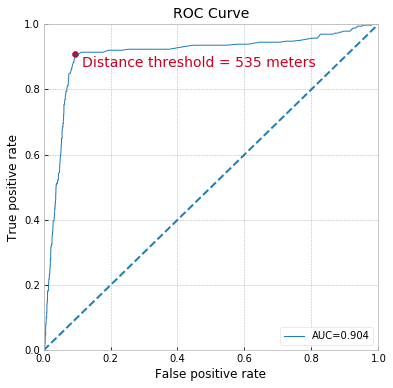

In [6]:
#
# Create the ROC curve and plot it to determine the optimal threshold
#
fpr, tpr, th = roc_curve(~df_dist['y_true'], # This is reversed as the target is "below" the threshold not "above".
                         df_dist['nearest_distance'])
#
# Calculate the area of the curve
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(6, 6), facecolor='white')
ax = fig.add_subplot(111)
ax.set_facecolor('white')
ax.plot(fpr, tpr, lw=1, color='#0571b0', alpha=0.9)

#
# Find the optimal threshold in distance
optimal_idx = np.argmax(tpr - fpr)
optimal_th = th[optimal_idx]

ax.scatter(fpr[optimal_idx], tpr[optimal_idx], color='#ca0020')
ax.text(fpr[optimal_idx]+0.02, tpr[optimal_idx]-0.04, 'Distance threshold = {} meters'.format(optimal_th), color='#ca0020', fontsize=14)
ax.plot([0,1],[0,1], "--", color='#0571b0', alpha=0.9)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title("ROC Curve", fontsize=14)
ax.set_ylabel('True positive rate', fontsize=12)
ax.set_xlabel('False positive rate', fontsize=12)
ax.grid(zorder=2)
ax.legend(["AUC={:.3f}".format(roc_auc)], loc=4, facecolor='white')
plt.show()

# PALSAR-2 detections

In [18]:
#
# Plot pair-trawler detections based on SAR detection
#
def sar_pair_trawlers(df, title, sar_boundary, eez_boundary):
    ## default map setting
    llcrnrlon = 127
    urcrnrlon = 137
    llcrnrlat = 36.5
    urcrnrlat = 43.5

    ## default Basemap setting
    fig = plt.figure(figsize=(8,8), dpi=150)
    ax = fig.add_subplot(111)
    m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
                lat_ts=0, projection='mill', resolution="l")
    m.drawmapboundary(fill_color='white',color='white',zorder=0.5)
    m.fillcontinents(color='#E5E5E5',lake_color='#E5E5E5',zorder=1) #01153e #49759c
    m.drawcountries(color='white', linewidth=1.5)

    ## set longitude, latitude ticks on x- and y-axes
    gap_lat = 3
    gap_lon = 4
    med_lat = 40.0
    med_lon = 132.0
    num_tick_lat = 3
    num_tick_lon = 4
    m.drawparallels(np.arange(med_lat-gap_lat, med_lat+gap_lat+1, gap_lat),labels=[1,0,0,0],linewidth=0.01,zorder=0)
    m.drawmeridians(np.arange(med_lon-gap_lon, med_lon+gap_lon+1, gap_lon),labels=[0,0,0,1],linewidth=0.01,zorder=0)
    
    ## Read boundary shapefiles
    m.readshapefile(_study_area,'sa',zorder=1.5,linewidth=1.5,color='#E5E5E5')
    prk = m.readshapefile(_eez_prk_no_shoreline,'prk',zorder=1.,linewidth=1.5,color='#e5e5e5')
    prk[-1].set_linestyle('--')
    m.readshapefile(sar_boundary,'sar',zorder=2,linewidth=4,color='#9ecae1')

    m.plot([], [], linewidth=1.5, alpha=0.8, color='#CCCCCC', label='Study area')
    m.plot([], [], linewidth=1.5, linestyle='--', alpha=0.8, color='#CCCCCC', label='EEZ claimed by N.Korea')
    m.plot([], [], linewidth=6, alpha=1, color='#9ecae1', label='PALSAR-2 detection boundary')


    #
    # Plot basic positions and path  
    pairt = df[df['pair_trawler']]
    other = df[df['pair_trawler']==False]
    lon, lat = m(pairt['lon'].values, pairt['lat'].values)
    m.scatter(lon, lat, color='#bd0026', s=7, alpha=0.2, zorder=2, label='Likely pair-trawlers')
    lon, lat = m(other['lon'].values, other['lat'].values)
    m.scatter(lon, lat, color='#045a8d', s=7, alpha=0.2, zorder=2, label='Other vessels')

    #
    # Handle legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [3,4,2,0,1]
    leg = plt.legend([handles[idx] for idx in order],
                     [labels[idx] for idx in order], 
                     loc=4, bbox_to_anchor=(1.0,-0.0),
                     frameon=False, markerscale=2, fontsize=12, labelspacing=0.3)

    for text in leg.get_texts():
        text.set_color("black")
        text.set_fontsize(14)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    for p in leg.get_patches():
        p.set_color('#E5E5E5')
        p.set_alpha(1)

    #
    # axes, figures, labels, title
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
    n1 = len(sar_within(pairt, eez_boundary))
    n2 = len(sar_within(other, eez_boundary))
        
    print(n1,n2)
    fig.text(0.045, 0.875, title, fontsize=24, ha='left', va='top') 
    fig.text(0.5, 0.85, 'Estimated pair trawlers in study area: {}'.format(n1), 
             fontsize=18, ha='center')
    print('Estimated number of pair-trawlers in study area: {}'.format(n1))
    
    fig.tight_layout()
    plt.subplots_adjust()
    plt.show()

In [15]:
#
# Plot combined map of SAR and VIIRS
#
def sar_viirs_combined(sar, viirs, boundary, time1, time2, title):
    ## default map setting
    llcrnrlon = 127
    urcrnrlon = 137
    llcrnrlat = 36.5
    urcrnrlat = 43.5

    #
    # default Basemap setting
    fig = plt.figure(figsize=(8,8), dpi=150)
    ax = fig.add_subplot(111)
    m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
                lat_ts=0, projection='mill',resolution="l")
    m.drawmapboundary(fill_color='white',color='white',zorder=0.5) #49759c
    m.fillcontinents(color='#E5E5E5',lake_color='#E5E5E5',zorder=1) #01153e #49759c
    m.drawcountries(color='white',linewidth=1.5)
    
    #
    # set longitude, latitude ticks on x- and y-axes
    gap_lat = 3
    gap_lon = 4
    med_lat = 40.0
    med_lon = 132.0
    num_tick_lat = 3
    num_tick_lon = 4
    m.drawparallels(np.arange(med_lat-gap_lat, med_lat+gap_lat+1, gap_lat),labels=[1,0,0,0],linewidth=0.01,zorder=0)
    m.drawmeridians(np.arange(med_lon-gap_lon, med_lon+gap_lon+1, gap_lon),labels=[0,0,0,1],linewidth=0.01,zorder=0)

    #
    # Read boundary shapefiles
    m.readshapefile(_study_area, 'sa', zorder=1.5,
                    linewidth=1.5, color='#E5E5E5')
    prk = m.readshapefile(_eez_prk_no_shoreline, 'prk', zorder=1.,
                          linewidth=1.5, color='#e5e5e5')
    prk[-1].set_linestyle('--')
    m.readshapefile(boundary,'sar', zorder=2,
                    linewidth=4, color='#9ecae1') 
    
    #
    # Plot basic positions and path
    for n_df, df in enumerate([viirs, sar]):
        #
        # For VIIRS display
        if n_df==0:
            cmap_viirs = ("#FDC24B", "#FA792F", "#AD001D")
            c = cmap_viirs

            color_ramp = [[c[0], 0, 0],
                      [c[1], 50, 50],
                      [c[2], 100, 100]]

            tm = 100.0 #this is just to scale the the following... this makes the colormap
            cdict = { 'red':tuple((color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in color_ramp ),
                      'green':tuple((color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in color_ramp ),
                      'blue':tuple((color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in color_ramp )}
    
            cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 256)
            cmap.set_bad(alpha = 0.0)
            color = cmap([col/1000.0 for col in df['Rad_DNB'].values])

            lon = df['Lon_DNB'].values
            lat = df['Lat_DNB'].values
            lon, lat = m(lon, lat)
            m.scatter(lon, lat, c=color, cmap=cmap, s=8, alpha=0.8, 
                      edgecolors='face', zorder=2)
         
        #
        # For SAR display
        if n_df==1:
            lon, lat = m(df['lon'].values, df['lat'].values)
            scat_s = m.scatter(lon, lat, color='#045a8d', s=8, alpha=0.15, 
                               zorder=2, label='Boat detected using PALSAR-2')
            m.plot([], [], linewidth=1.5, alpha=0.8, 
                   color='#CCCCCC', label='Study area')
            m.plot([], [], linewidth=1.5, linestyle='--', alpha=0.8, 
                   color='#CCCCCC', label='EEZ claimed by N.Korea')
            m.plot([], [], linewidth=6, alpha=1, 
                   color='#9ecae1', label='PALSAR-2 detection boundary')



    #
    # Handle legend
    raw_handles, raw_labels = plt.gca().get_legend_handles_labels()
    handles = []
    labels = []
    for idx in [0, 1, None, 2, 3, None, 
                (1000.0, 'Brightest, mostly Chinese'), 
                (500.0, 'Intermediate, Chinese or South Korean'), 
                (1.0, 'Dimmest, mostly North Korean')]:
        if idx is None:
            h = matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                     visible=False)
            handles.append(h)
            labels.append('')
        elif isinstance(idx, tuple):
            intensity, txt = idx
            
            h = Line2D([0], [0], marker='o', color=cmap(intensity / 1000), label='Scatter',
                          markerfacecolor=cmap(intensity / 1000), markersize=3, linewidth=0)
            handles.append(h)
            labels.append(txt) 
        else:
            handles.append(raw_handles[idx])
            labels.append(raw_labels[idx])
    leg = plt.legend(handles, labels, loc=4, bbox_to_anchor=(1.0,-0.0), #ncol=2, 
                       frameon=False, markerscale=2, fontsize=10, labelspacing=0.2,
                     borderaxespad=0.0) #prop=rbt_reg, 

    for text in leg.get_texts():
        text.set_color("black")
        text.set_fontsize(11)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    for p in leg.get_patches():
        p.set_color('#E5E5E5')
        p.set_alpha(1)

    dy = 0.0
    dx = 0.52
    fig.text(dx, 0.25 + dy, 'PALSAR-2 SAR detections ({})'.format(time1), 
             fontsize=12, fontweight='bold')
    fig.text(dx, 0.18 + dy, 'VIIRS detections ({})'.format(time2), 
             fontsize=12, fontweight='bold')
        
    #
    # Add colorbar
    norm = colors.Normalize(vmin = 0, vmax = 1000) 
    ax2 = fig.add_axes([0.53, 0.113, 0.02, 0.06])
    cb = colorbar.ColorbarBase(ax2, norm = norm, orientation='vertical', cmap = cmap)

    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.set_yticklabels(['0', '>1000'])  # vertically oriented colorbar

    cb.ax.tick_params(direction='out', pad=2, length=3)
    cb.ax.yaxis.set_major_locator(plt.MaxNLocator(1))
    tl = cb.ax.get_yticklabels()
    #
    # set the alignment for the first and last
    tl[0].set_verticalalignment('bottom')
    tl[-1].set_verticalalignment('top')

    #
    # axes, figures, labels, title
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    fig.text(.045, 0.875, title, fontsize=24, ha='left', va='top') #fontproperties=rbt_reg, 

    fig.tight_layout()
    plt.show()

# Fig.S8 - PALSAR-2 boat detections overlapped with VIIRS night light detections

## 2017-10-24

In [10]:
#
# PALSAR-2 vessel detections
#
q = """
# StandardSQL
#
# Pull all data points of the SAR detection
SELECT lat, lon
FROM `paper_dark_fishing_fleets_in_north_korea.sar_palsar2_detections_20171024`
"""
s20171024 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

#
# Likely pair trawlers based on PALSAR-2 vessel detection
#
q = """
# StandardSQL
#
# Detect likely pair trawlers based on the distance to the nearest neighbor
WITH 
  #
  # Data points of the SAR detection
  data AS (
    SELECT 
      CONCAT(SAFE_CAST(date AS STRING), '_' ,
            SAFE_CAST(ROUND(lat,6) AS STRING), '_',
            SAFE_CAST(ROUND(lon,6) AS STRING)) AS vid, 
      *
    FROM (
      SELECT 
        ST_GEOGPOINT(lon, lat) AS loc, 
        lat, lon, Date(date) AS date
      FROM `paper_dark_fishing_fleets_in_north_korea.sar_palsar2_detections_20171024` ) 
  ),

  #
  # Area of interest (within the claimed N.Korea EEZ excluding the military zone)
  aoi AS (
    SELECT aoi AS polygon
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_eez_wo_mz` 
  ),
    
  #
  # Shorelines of the eastern part of N.Korea
  sl AS (
    SELECT ST_MAKELINE(shoreline) AS shorelines 
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_shorelines`
  )
  
#
# Mark the data points whose nearest neighbor is located within 535 meters
# and whether the data points are within the area of interest
SELECT 
  vid, date, lat, lon, in_aoi, 
  IF(nearest<=535, TRUE, FALSE) pair_trawler
FROM (
  SELECT 
    vid, date, lat, lon, distance, 
    FIRST_VALUE(distance) OVER (PARTITION BY vid ORDER BY distance ASC) nearest, 
    IF(ST_CONTAINS( (SELECT polygon FROM aoi), loc), TRUE, FALSE) in_aoi
  FROM (
    #
    # Cross-join the dataset to calculate the distance 
    # between each data points on the same date
    SELECT 
      vid, date, lat, lon, loc, 
      ST_DISTANCE(loc, loc2) AS distance, 
      vid2 
    FROM data a
    JOIN (
      SELECT vid AS vid2, date, loc AS loc2 
      FROM data ) b
    USING (date) )
  #
  # Remove the points themselves (with the distance = 0)
  # and filter in only those that are 12 nautical miles away from the coastline
  WHERE vid != vid2
    AND ST_DISTANCE(loc, (SELECT shorelines FROM sl)) > 22224 ) -- 22224 meters is
                                                                -- 12 nautical miles
WHERE nearest = distance
"""
st20171024 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [11]:
#
# VIIRS night light detections 
#
q = """
# StandardSQL
WITH
  #
  # VIIRS raw data in the region for 2017
  data AS (
    SELECT *
    FROM `paper_dark_fishing_fleets_in_north_korea.viirs_east_asia_2017`
  )
 
#
# Slice the data for 2017-10-24
SELECT *
FROM data
WHERE Date_Mscan BETWEEN TIMESTAMP('2017-10-24') AND TIMESTAMP('2017-10-25')
"""
v20171024 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

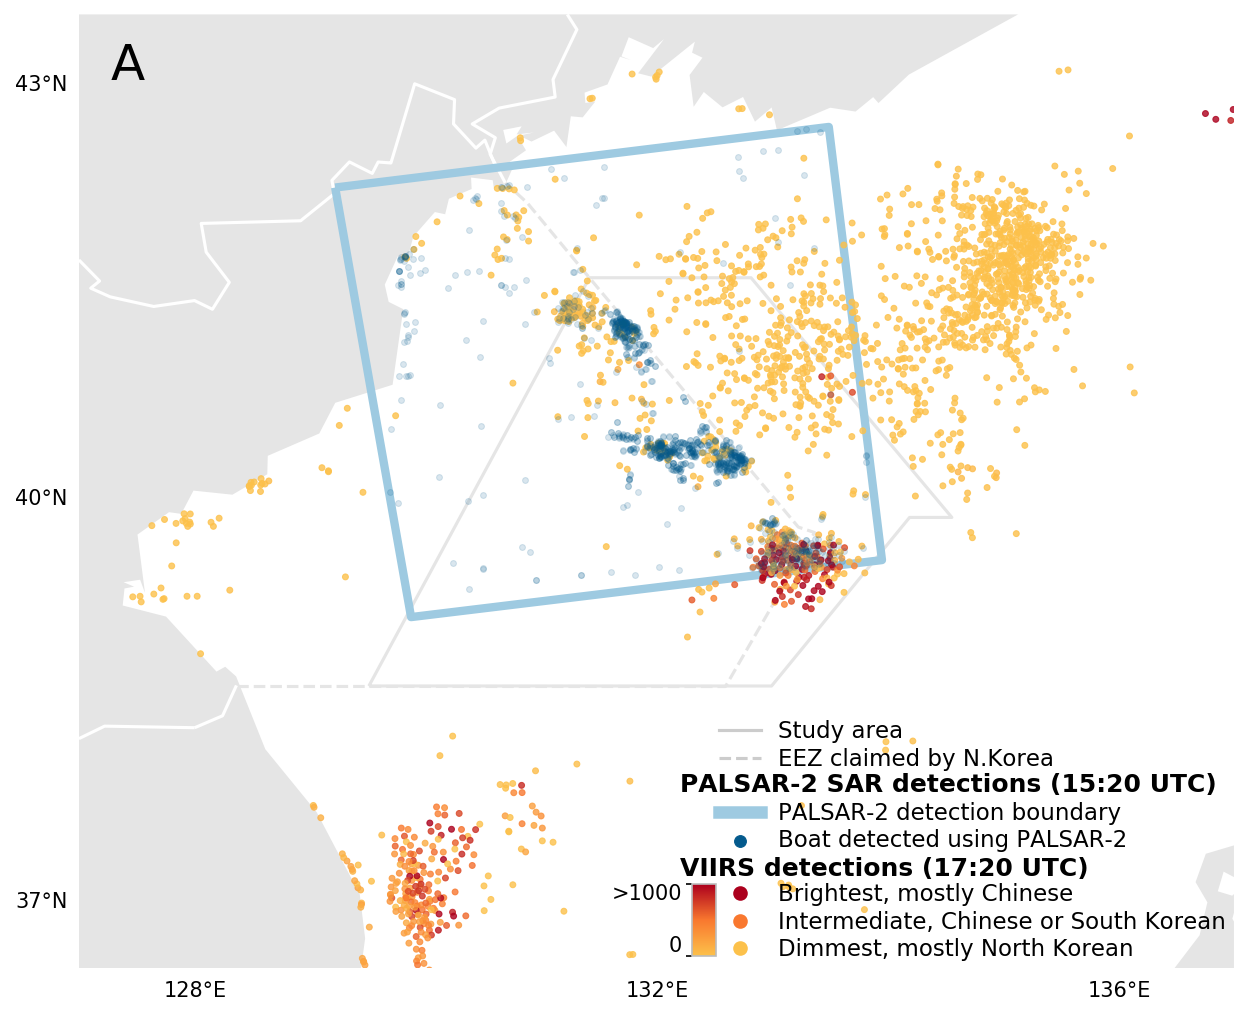

In [16]:
sar_viirs_combined(s20171024, v20171024, _palsar_20171024, '15:20 UTC', '17:20 UTC', 'A')

(796, 206)
Estimated number of pair-trawlers in study area: 796


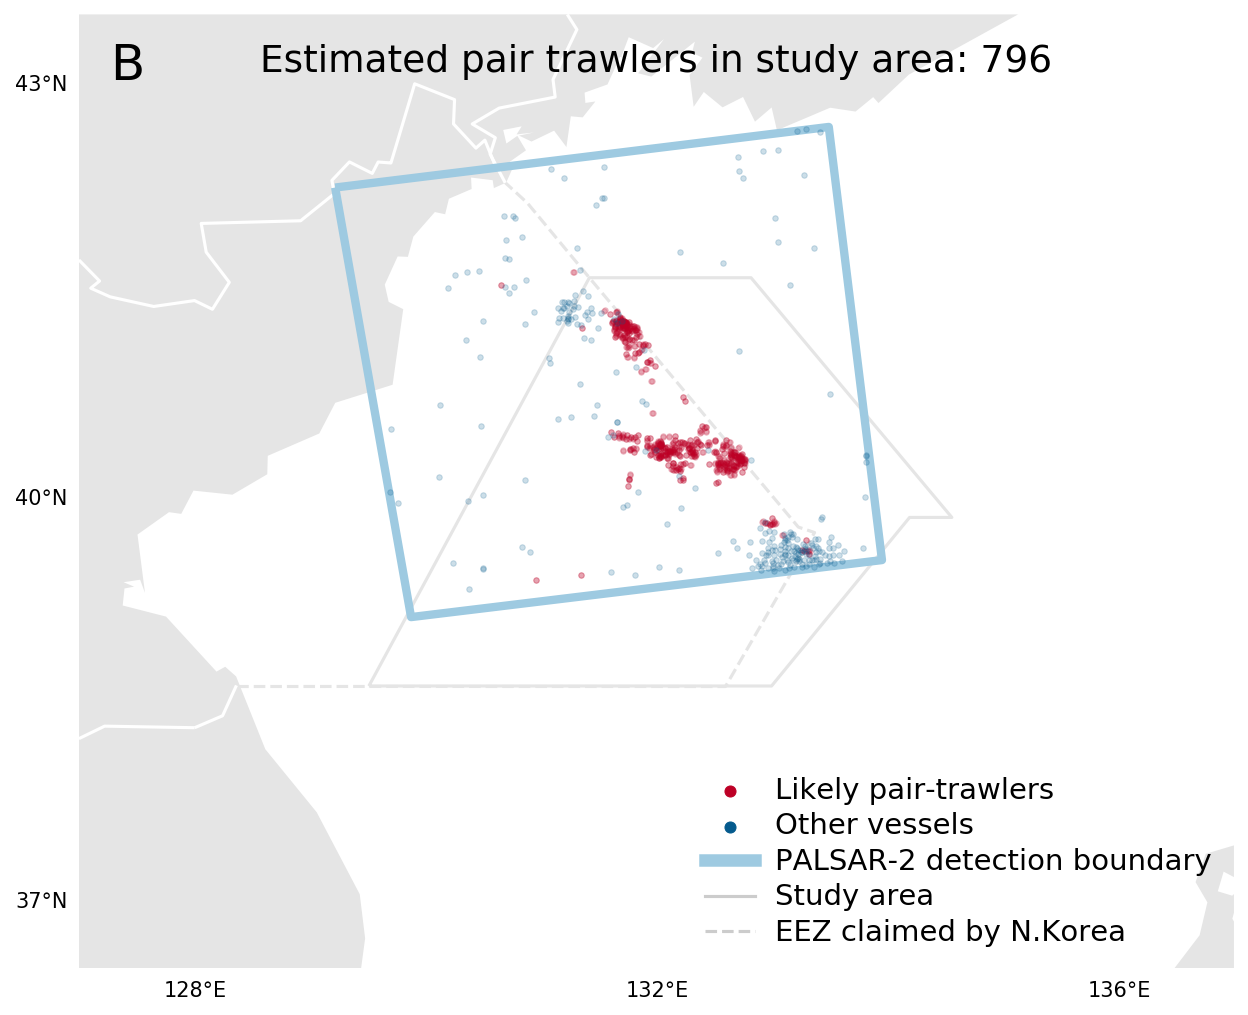

In [19]:
sar_pair_trawlers(st20171024, 'B', _palsar_20171024, _study_area)

## 2017-10-02

In [20]:
#
# PALSAR-2 vessel detections
#
q = """
# StandardSQL
#
# Pull all data points of the SAR detection
SELECT lat, lon
FROM `paper_dark_fishing_fleets_in_north_korea.sar_palsar2_detections_20171002`
"""
s20171002 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

#
# Likely pair trawlers based on PALSAR-2 vessel detection
#
q = """
# StandardSQL
#
# Detect likely pair trawlers based on the distance to the nearest neighbor
WITH 
  #
  # Data points of the SAR detection
  data AS (
    SELECT 
      CONCAT(SAFE_CAST(date AS STRING), '_' ,
            SAFE_CAST(ROUND(lat,6) AS STRING), '_',
            SAFE_CAST(ROUND(lon,6) AS STRING)) AS vid, 
      *
    FROM (
      SELECT 
        ST_GEOGPOINT(lon, lat) AS loc, 
        lat, lon, Date(date) AS date
      FROM `paper_dark_fishing_fleets_in_north_korea.sar_palsar2_detections_20171002` ) 
  ),

  #
  # Area of interest (within the claimed N.Korea EEZ excluding the military zone)
  aoi AS (
    SELECT aoi AS polygon
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_eez_wo_mz` 
  ),
    
  #
  # Shorelines of the eastern part of N.Korea
  sl AS (
    SELECT ST_MAKELINE(shoreline) AS shorelines 
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_shorelines`
  )
  
#
# Mark the data points whose nearest neighbor is located within 535 meters
# and whether the data points are within the area of interest
SELECT 
  vid, date, lat, lon, in_aoi, 
  IF(nearest<=535, TRUE, FALSE) AS pair_trawler
FROM (
  SELECT 
    vid, date, lat, lon, distance, 
    FIRST_VALUE(distance) OVER (PARTITION BY vid ORDER BY distance ASC) AS nearest, 
    IF(ST_CONTAINS( (SELECT polygon FROM aoi), loc), TRUE, FALSE) AS in_aoi
  FROM (
    #
    # Cross-join the dataset to calculate the distance 
    # between each data points on the same date
    SELECT 
      vid, date, lat, lon, loc, 
      ST_DISTANCE(loc, loc2) AS distance, 
      vid2 
    FROM data a
    JOIN (
      SELECT vid AS vid2, date, loc AS loc2 
      FROM data ) b
    USING (date) )
  #
  # Remove the points themselves (with the distance = 0)
  # and filter in only those that are 12 nautical miles away from the coastline
  WHERE vid != vid2
    AND ST_DISTANCE(loc, (SELECT shorelines FROM sl)) > 22224 )
WHERE nearest = distance
"""
st20171002 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [21]:
#
# VIIRS night light detections 
#
q = """
# StandardSQL
WITH
  #
  # VIIRS raw data in the region for 2017
  data AS (
    SELECT *
    FROM `paper_dark_fishing_fleets_in_north_korea.viirs_east_asia_2017`
  )
 
#
# Slice the data for 2017-10-02
SELECT *
FROM data
WHERE Date_Mscan BETWEEN TIMESTAMP('2017-10-01') AND TIMESTAMP('2017-10-02')
"""
v20171002 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

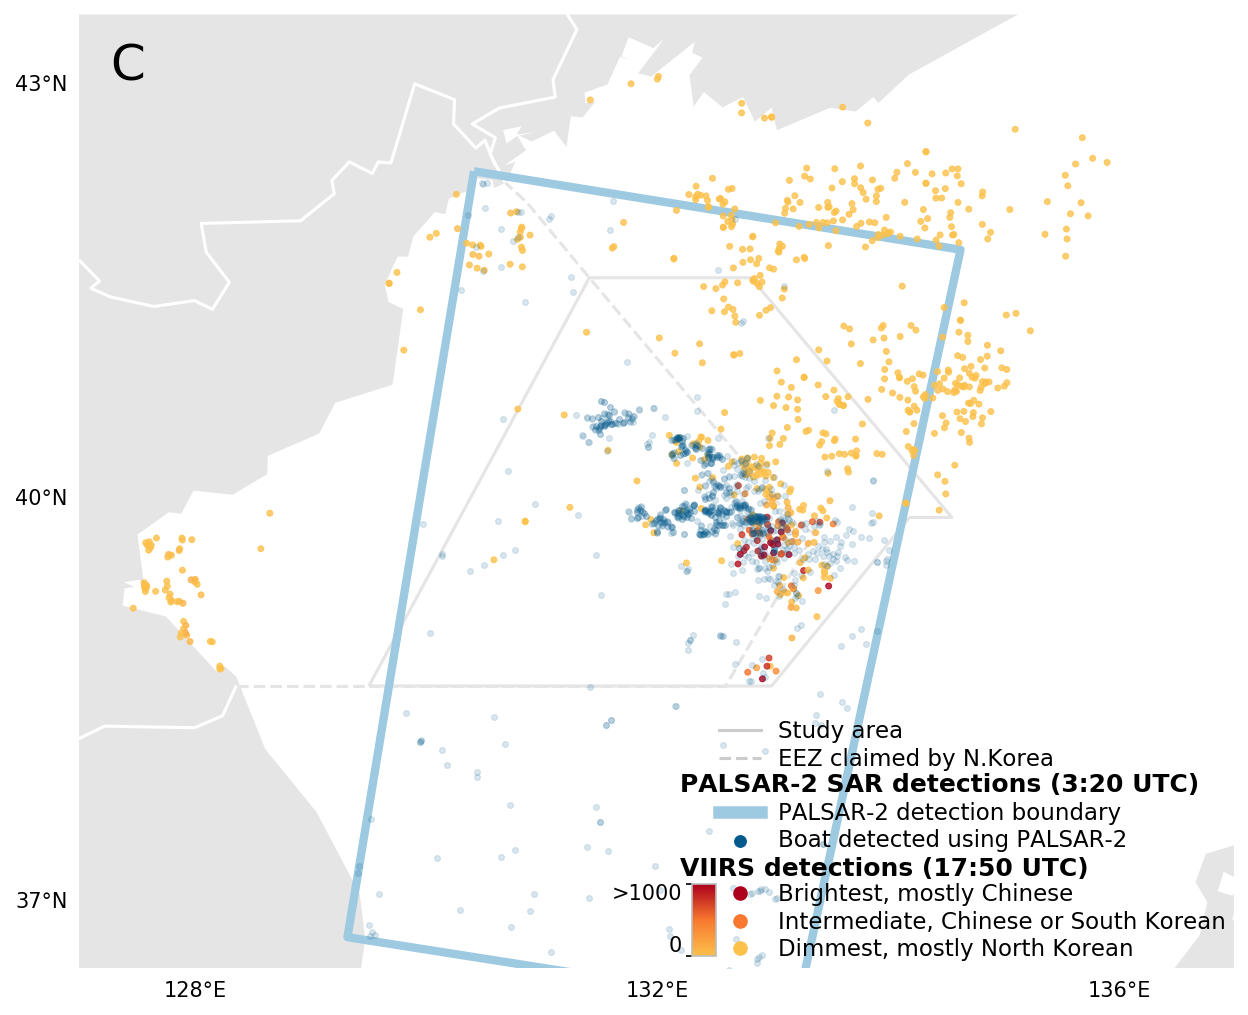

In [22]:
sar_viirs_combined(s20171002, v20171002, _palsar_20171002, '3:20 UTC', '17:50 UTC', 'C')

(551, 312)
Estimated number of pair-trawlers in study area: 551


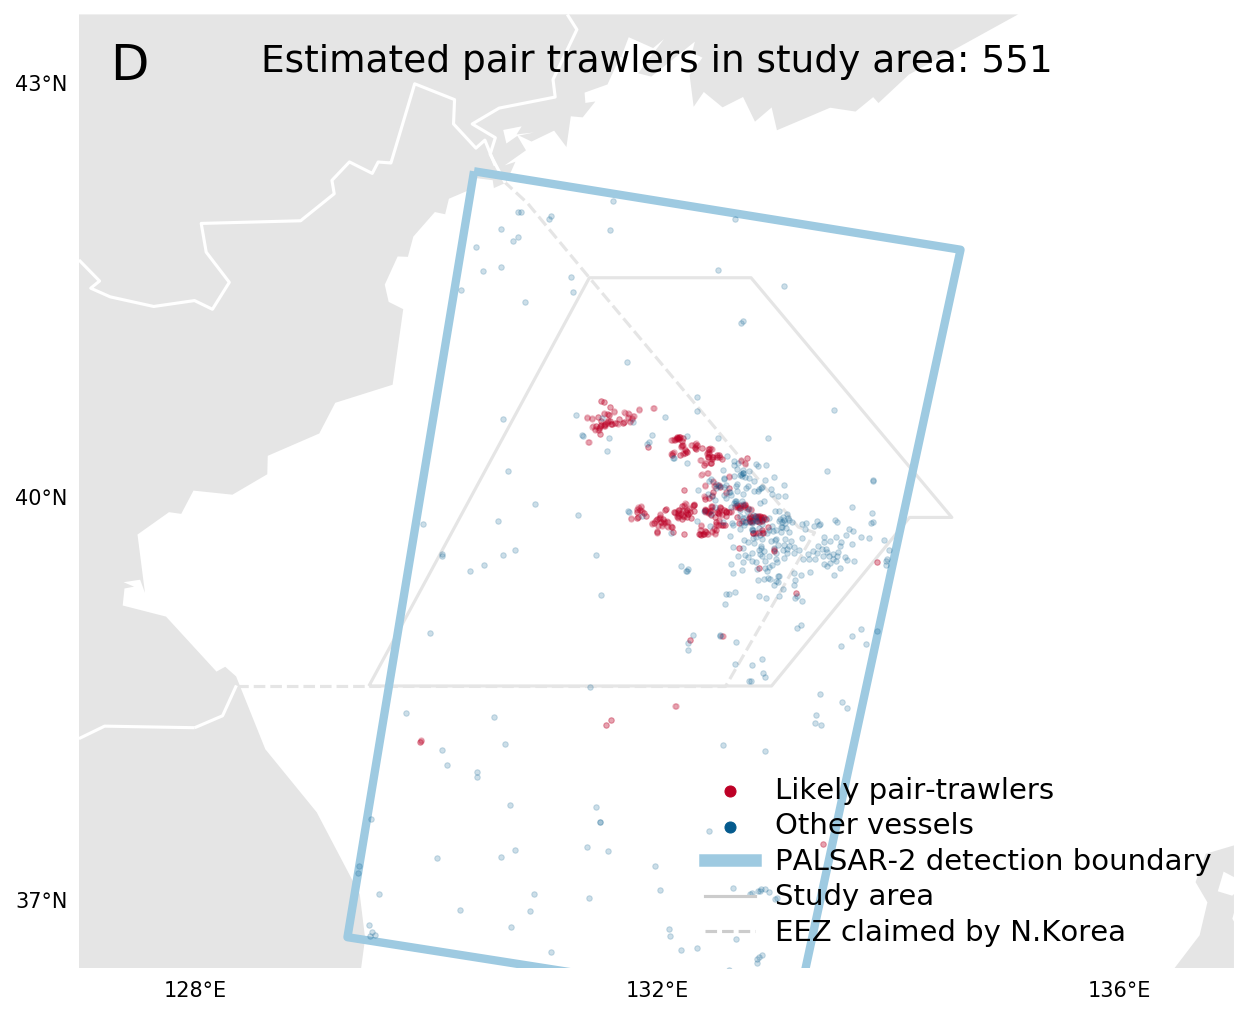

In [23]:
sar_pair_trawlers(st20171002, 'D', _palsar_20171002, _study_area)

## 2017-09-27

In [24]:
#
# PALSAR-2 vessel detections
#
q = """
# StandardSQL
#
# Pull all data points of the SAR detection
SELECT lat, lon
FROM `paper_dark_fishing_fleets_in_north_korea.sar_palsar2_detections_20170927`
"""
s20170927 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

#
# Likely pair trawlers based on PALSAR-2 vessel detection
#
q = """
# StandardSQL
#
# Detect likely pair trawlers based on the distance to the nearest neighbor
WITH 
  #
  # Data points of the SAR detection
  data AS (
    SELECT 
      CONCAT(SAFE_CAST(date AS STRING), '_' ,
            SAFE_CAST(ROUND(lat,6) AS STRING), '_',
            SAFE_CAST(ROUND(lon,6) AS STRING)) AS vid, 
      *
    FROM (
      SELECT 
        ST_GEOGPOINT(lon, lat) AS loc, 
        lat, lon, Date(date) AS date
      FROM `paper_dark_fishing_fleets_in_north_korea.sar_palsar2_detections_20170927` ) 
  ),

  #
  # Area of interest (within the claimed N.Korea EEZ excluding the military zone)
  aoi AS (
    SELECT aoi AS polygon
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_eez_wo_mz` 
  ),
    
  #
  # Shorelines of the eastern part of N.Korea
  sl AS (
    SELECT ST_MAKELINE(shoreline) AS shorelines 
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_shorelines`
  )
  
#
# Mark the data points whose nearest neighbor is located within 535 meters
# and whether the data points are within the area of interest
SELECT 
  vid, date, lat, lon, in_aoi, 
  IF(nearest<=535, TRUE, FALSE) AS pair_trawler
FROM (
  SELECT 
    vid, date, lat, lon, distance, 
    FIRST_VALUE(distance) OVER (PARTITION BY vid ORDER BY distance ASC) AS nearest, 
    IF(ST_CONTAINS( (SELECT polygon FROM aoi), loc), TRUE, FALSE) AS in_aoi
  FROM (
    #
    # Cross-join the dataset to calculate the distance 
    # between each data points on the same date
    SELECT 
      vid, date, lat, lon, loc, 
      ST_DISTANCE(loc, loc2) AS distance, 
      vid2 
    FROM data a
    JOIN (
      SELECT vid AS vid2, date, loc AS loc2 
      FROM data ) b
    USING (date) )
  #
  # Remove the points themselves (with the distance = 0)
  # and filter in only those that are 12 nautical miles away from the coastline
  WHERE vid != vid2
    AND ST_DISTANCE(loc, (SELECT shorelines FROM sl)) > 22224 )
WHERE nearest = distance
"""
st20170927 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [25]:
#
# VIIRS night light detections 
#
q = """
# StandardSQL
WITH
  #
  # VIIRS raw data in the region for 2017
  data AS (
    SELECT *
    FROM `paper_dark_fishing_fleets_in_north_korea.viirs_east_asia_2017`
  )
 
#
# Slice the data for 2017-09-27
SELECT *
FROM data
WHERE Date_Mscan BETWEEN TIMESTAMP('2017-09-26') AND TIMESTAMP('2017-09-27')
"""
v20170927 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

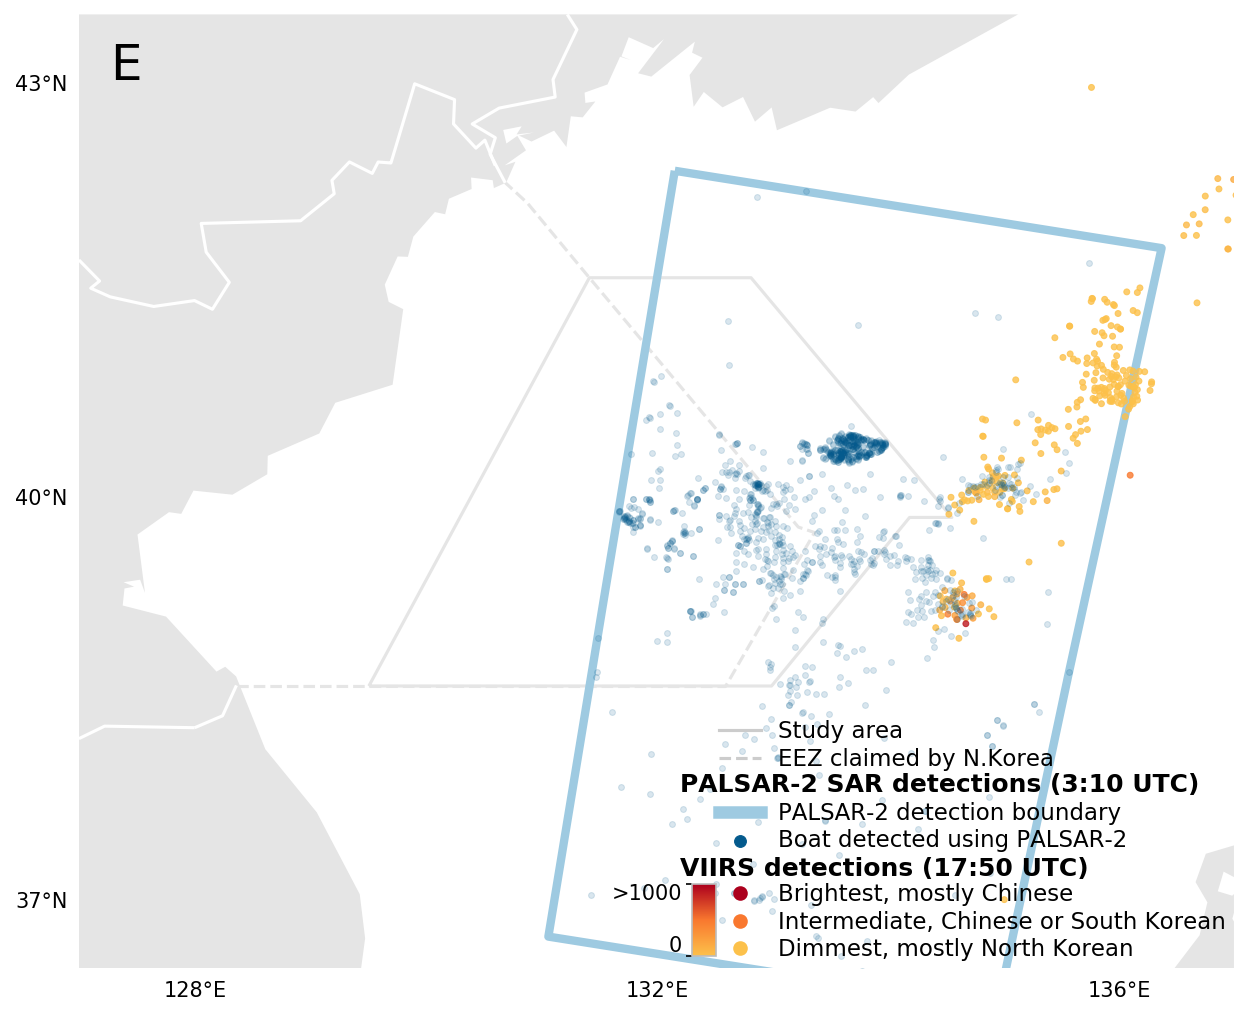

In [26]:
sar_viirs_combined(s20170927, v20170927, _palsar_20170927, '3:10 UTC', '17:50 UTC', 'E')

(545, 373)
Estimated number of pair-trawlers in study area: 545


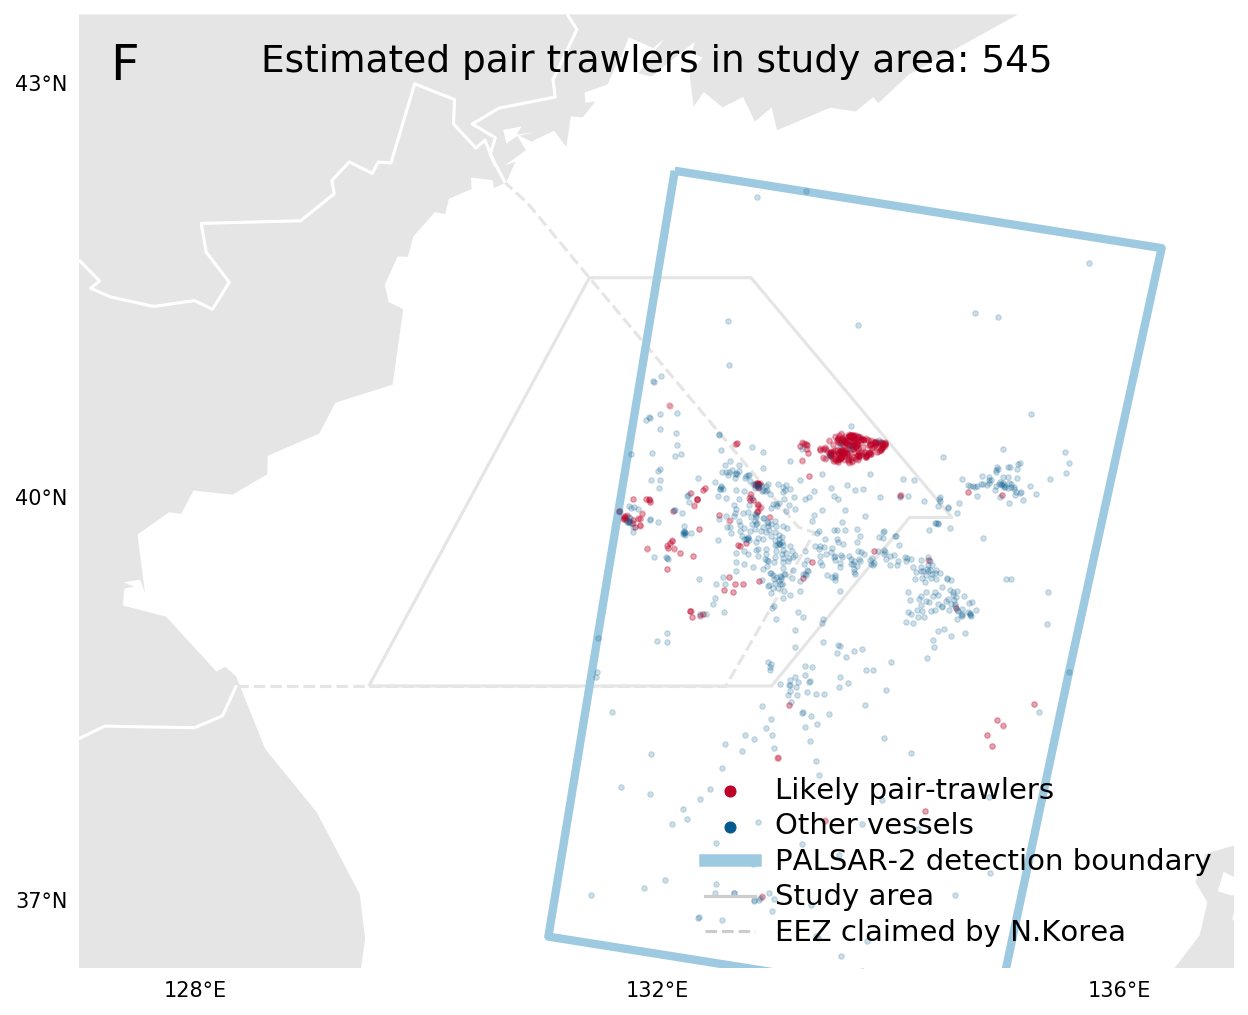

In [27]:
sar_pair_trawlers(st20170927, 'F', _palsar_20170927, _study_area)

# Fig.3D - Identification of Chinese and North Korean lighting vessels through combining SAR and VIIRS

In [28]:
#
# Create Fig.3D to combine SAR and VIIRS vessel detections
#
def sar_viirs_combined_fig3d(sar, viirs, title):
    #
    # default map setting
    llcrnrlon = 128
    urcrnrlon = 136
    llcrnrlat = 36.1
    urcrnrlat = 43.1

    #
    # default Basemap setting
    fig = plt.figure(figsize=(3.75,3.75), facecolor='white', dpi=300)
    ax = fig.add_subplot(111)
    m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
                lat_ts=0, projection='mill',resolution="l")
    m.drawmapboundary(fill_color='white', color='#b2b2b2', linewidth=0.5) 
    m.fillcontinents(color='#E5E5E5', lake_color='#E5E5E5', zorder=1) 
    m.drawcountries(color='white', linewidth=1, zorder=1.5)

    #
    # Read boundary shapefiles
    m.readshapefile(_study_area, 'sa', zorder=1.5, 
                    linewidth=0.8, color='#b2b2b2')
    prk = m.readshapefile(_eez_prk_no_shoreline, 'prk', zorder=1., 
                          linewidth=0.6, color='#b2b2b2')
    prk[-1].set_linestyle('--')

    #
    # Plot vessel detections
    for n_df, df in enumerate([viirs, sar]):
        #
        # VIIRS display
        if n_df==0:
            
            #
            # Colormap setting
            cmap_viirs = ("#FDC24B", "#FA792F", "#AD001D")
            c = cmap_viirs

            color_ramp = [[c[0],0,0],
                          [c[1],50,50],
                          [c[2],100,100]]

            tm = 100.0
            cdict = { 'red':tuple((color[2]/tm, int(color[0][1:3],16)/256.0, int(color[0][1:3],16)/256.0) for color in color_ramp ),
                      'green':tuple((color[2]/tm, int(color[0][3:5],16)/256.0, int(color[0][3:5],16)/256.0) for color in color_ramp ),
                      'blue':tuple((color[2]/tm, int(color[0][5:7],16)/256.0, int(color[0][5:7],16)/256.0) for color in color_ramp )}
    
            cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 256)
            cmap.set_bad(alpha = 0.0)
            color = cmap([col/1000.0 for col in df['Rad_DNB'].values])

            # 
            # Map VIIRS vessel detections
            lon = df['Lon_DNB'].values
            lat = df['Lat_DNB'].values
            lon, lat = m(lon, lat)
            m.scatter(lon, lat, c=color, cmap=cmap, s=2, alpha=0.6, 
                      edgecolors='face', zorder=2)
            
        #
        # SAR display
        if n_df==1:
            s=2
            lon, lat = m(df['lon'].values, df['lat'].values)
            m.scatter(lon, lat, color='#045a8d', s=s, alpha=0.2, zorder=2, label='Vessels')
            #
            # Add legend labels
            m.plot([], [], linewidth=0.8, alpha=0.8, color='#b2b2b2', 
                   label='Study area')
            m.plot([], [], linewidth=0.8, linestyle='--', alpha=0.8, color='#b2b2b2', 
                   label='Claimed North Korean EEZ')
            m.plot([], [], linewidth=1.0, alpha=0.5, color='#045a8d', 
                   label='Detection boundary')
            
            #
            # Boundary
            boundary = [[129.218532,42.261774],
                        [133.492260,42.696840],
                        [133.952754,39.548580],
                        [129.875802,39.127558],
                        [129.218532,42.261774]]
            boundary = pd.DataFrame(boundary, columns=['lon','lat'])
            lon, lat = m(boundary['lon'].values, boundary['lat'].values)
            m.plot(lon, lat, linewidth=2.0, c='#045a8d', alpha=0.4, zorder=1.5)
            
    #
    # Additional texts for legend
    fig.text(0.37,0.279, 'SAR detections of pair trawlers\n2017-10-24 15:20 UTC', 
             fontsize=6, fontweight='bold')
    fig.text(0.37,0.171, 'VIIRS detections of lighting vessels\n2017-10-24 17:20 UTC', 
             fontsize=6, fontweight='bold')
    
    fig.text(0.53,0.497, '(i)', fontsize=7)
    fig.text(0.47,0.63, '(ii)', fontsize=7)
    fig.text(0.548,0.685, '(iii)', fontsize=7)
    fig.text(0.28,0.195, '(iv)', fontsize=7)

    #
    # Handle legend
    raw_handles, raw_labels = plt.gca().get_legend_handles_labels()
    handles = []
    labels = []
    for idx in [0, 1, None, None, 2, 3, None, None,
                (1000.0, 'Brightest, mostly Chinese'), 
                (500.0, 'Intermediate, Chinese or South Korean'), 
                (1.0, 'Dimmest, mostly North Korean')]:
        if idx is None:
            h = matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                     visible=False)
            handles.append(h)
            labels.append('')
        elif isinstance(idx, tuple):
            intensity, txt = idx
            
            h = Line2D([0], [0], marker='o', color=cmap(intensity / 1000), label='Scatter',
                          markerfacecolor=cmap(intensity / 1000), markersize=1, linewidth=0)
            handles.append(h)
            labels.append(txt) 
        else:
            handles.append(raw_handles[idx])
            labels.append(raw_labels[idx])
            
    leg = plt.legend(handles, labels, loc=4, bbox_to_anchor=(1.0,-0.005), 
                     frameon=False, markerscale=2, fontsize=6, labelspacing=0.25,
                     borderaxespad=0.0) 

    for text in leg.get_texts():
        text.set_color("black")
        text.set_fontsize(6)
    for i, lh in enumerate(leg.legendHandles): 
        lh.set_alpha(1)
        if (i == 0) | (i == 1):
            lh.set_linewidth(0.8)
        if i == 4:
            lh.set_alpha(0.4)
            lh.set_linewidth(2.0)
    for p in leg.get_patches():
        p.set_color('#E5E5E5')
        p.set_alpha(1)
 
    #
    # Add colorbar
    norm = colors.Normalize(vmin = 0, vmax = 1000) 
    ax2 = fig.add_axes([0.38, 0.095, 0.02, 0.06])
    cb = colorbar.ColorbarBase(ax2, norm = norm, orientation='vertical', cmap = cmap)

    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.set_yticklabels(['0', '>1,000'])  # vertically oriented colorbar

    cb.ax.tick_params(direction='out', pad=1, length=3, labelsize=5, grid_linewidth=1)
    cb.ax.yaxis.set_major_locator(plt.MaxNLocator(1))
    tl = cb.ax.get_yticklabels()
    
    #
    # set the alignment for the first and last
    tl[0].set_verticalalignment('bottom')
    tl[-1].set_verticalalignment('top')
    

    frame = leg.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('white')
    frame.set_linewidth(1.)
    frame.set_alpha(0.8)

    #
    # Add ticks
    xtick1,_ = m(129,0)
    xtick2,_ = m(132,0)
    xtick3,_ = m(135,0)
    _,ytick1 = m(0,37)
    _,ytick2 = m(0,42)
    
    #
    # Axes    
    ax.set_xticks([xtick1,xtick3])
    ax.set_xticklabels(['129'+u"\u00b0"+'E','135'+u"\u00b0"+'E'])
    ax.tick_params(axis="x",direction="out",color='#b2b2b2',labelsize=5)
    ax.set_yticks([ytick1,ytick2])
    ax.set_yticklabels(['37'+u"\u00b0"+'N','42'+u"\u00b0"+'N'])
    ax.tick_params(axis="y",direction="out",color='#b2b2b2',labelsize=5)
    ax.yaxis.tick_right()
    ax.grid(False)
    fig.text(.06,0.905, title, fontsize=12, fontweight='heavy')
    
    fig.tight_layout() 
    plt.subplots_adjust()
    plt.show()

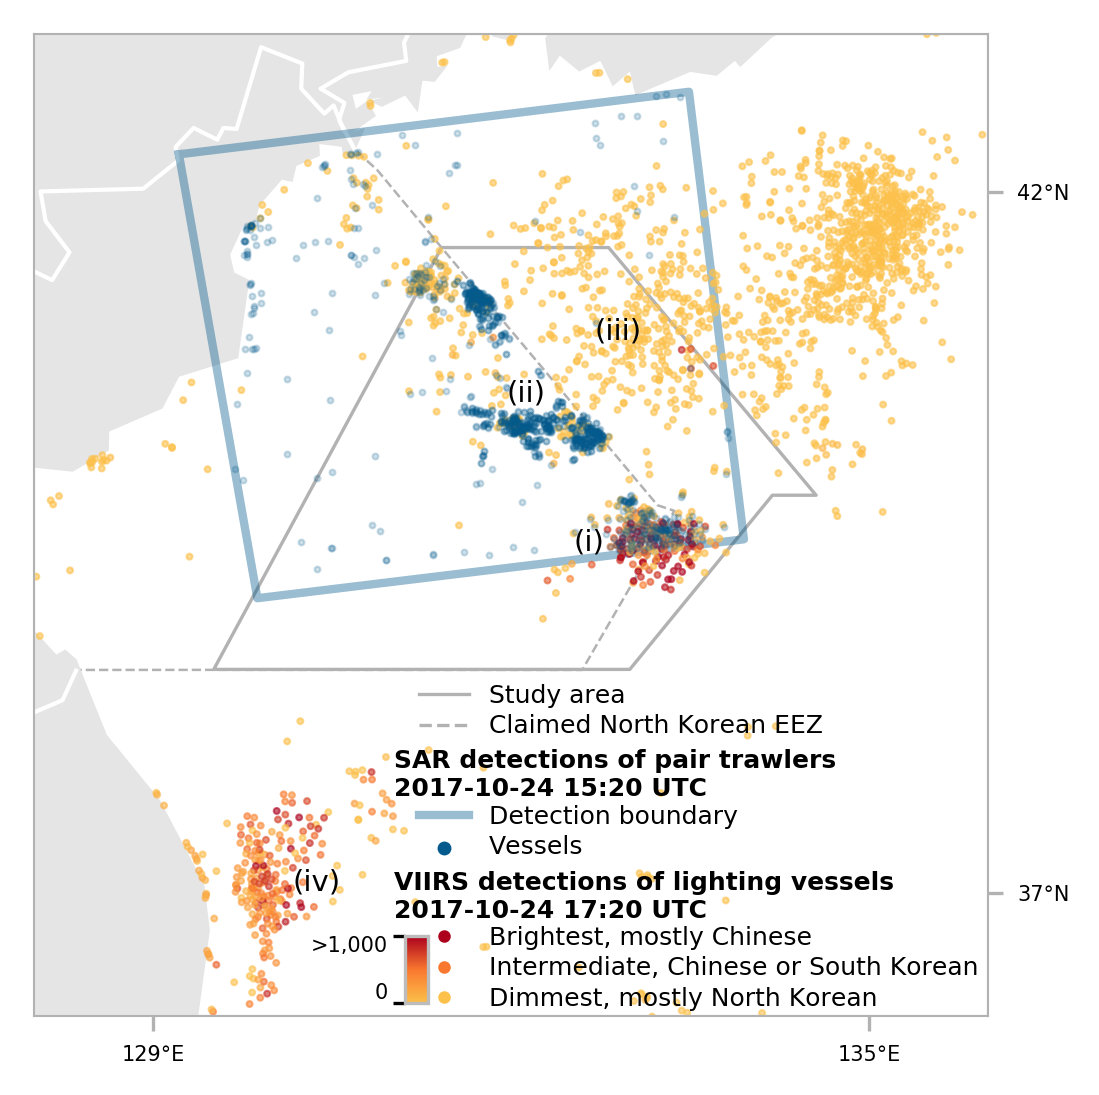

In [29]:
sar_viirs_combined_fig3d(s20171024, v20171024, '')

# RADARSAT-2 detections

In [30]:
#
# Likely pair trawlers based on RADARSAT-2 vessel detections
#
q = """
# StandardSQL
#
# Detect likely pair trawlers based on the distance to the nearest neighbor
WITH 
  #
  # Data points of the SAR detection
  data AS (
    SELECT 
      CONCAT(SAFE_CAST(date AS STRING), '_' ,
            SAFE_CAST(ROUND(lat,6) AS STRING), '_',
            SAFE_CAST(ROUND(lon,6) AS STRING)) AS vid, 
      *
    FROM (
      SELECT 
        ST_GEOGPOINT(lon, lat) AS loc, 
        lat, lon, date# AS date
      FROM `paper_dark_fishing_fleets_in_north_korea.sar_radarsat2_detections` ) 
  ),
    
  #
  # Shorelines of the eastern part of N.Korea
  sl AS (
    SELECT ST_MAKELINE(shoreline) AS shorelines 
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_shorelines`
  )
  
 
#
# Mark the data points whose nearest neighbor is located within 535 meters
# and whether the data points are within the area of interest
SELECT 
  vid, date, lat, lon,
  IF(nearest<=535, TRUE, FALSE) AS pair_trawler
FROM (
  SELECT 
    vid, date, lat, lon, distance, 
    FIRST_VALUE(distance) OVER (PARTITION BY vid ORDER BY distance ASC) AS nearest
  FROM (
    #
    # Cross-join the dataset to calculate the distance 
    # between each data points on the same date
    SELECT 
      vid, date, lat, lon, loc, 
      ST_DISTANCE(loc, loc2) AS distance, 
      vid2 
    FROM data a
    JOIN (
      SELECT vid AS vid2, date, loc AS loc2 
      FROM data ) b
    USING (date) )
  #
  # Remove the points themselves (with the distance = 0)
  # and filter in only those that are 12 nautical miles away from the coastline
  WHERE vid != vid2
    AND ST_DISTANCE(loc, (SELECT shorelines FROM sl)) > 22224 )
WHERE nearest = distance
"""
r2 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [31]:
#
# RADARSAT-2's boundary (7 different dates)
#
r2boundary = [[[42.431111, 128.823889],
               [41.796944, 134.349722],
               [37.341667, 133.254722],
               [37.998333, 128.079444],
               [42.431111, 128.823889]],
              [[41.266667, 130.731944],
               [41.903611, 136.209722],
               [37.473333, 136.955833],
               [36.813333, 131.819167],
               [41.266667, 130.731944]],
              [[42.742778, 130.070000],
               [44.229444, 135.414444],
               [39.866667, 137.350556],
               [38.478611, 132.300833],
               [42.742778, 130.070000]],
              [[41.960278, 129.456389],
               [43.426944, 134.740556],
               [39.103889, 136.612222],
               [37.731667, 131.610278],
               [41.960278, 129.456389]],
              [[42.128889, 130.879444],
               [41.493056, 136.377500],
               [37.086111, 135.298056],
               [37.744444, 130.141944],
               [42.128889, 130.879444]],
              [[42.129722, 130.880833],
               [41.493889, 136.379167],
               [37.086944, 135.299444],
               [37.745278, 130.143056],
               [42.129722, 130.880833]],
              [[42.248056, 130.345556],
               [43.722222, 135.652500],
               [39.357778, 137.558611],
               [37.980000, 132.540000],
               [42.248056, 130.345556]]]

In [32]:
#
# RADARSAT-2's acquisition dates
#
r2dates = r2['date'].unique()

In [35]:
def r2_plot():

    fig = plt.figure(figsize=(16,16), dpi=300)
    count=0
    vnum = []
    for i in range(len(r2dates)):
        date =r2dates[i]
        r2_date = r2[r2['date'] == date]

        #
        # default map setting
        llcrnrlon = 128.5
        urcrnrlon = 134.5
        llcrnrlat = 37.5
        urcrnrlat = 42.5

        col = int(count%3)
        row = int(count/3)

        #
        # default Basemap setting
        ax = fig.add_subplot(3,3, (row*3)+col+1)
        m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                    urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
                    lat_ts=0, projection='mill', resolution="l")
        m.drawmapboundary(fill_color='white', color='white', zorder=0.5)
        m.fillcontinents(color='#E5E5E5', lake_color='#E5E5E5', zorder=1) 
        m.drawcountries(color='white', linewidth=1.5)

        #
        # set longitude, latitude ticks on x- and y-axes
        gap_lat = 2
        gap_lon = 2.5
        med_lat = 40.0
        med_lon = 131.5
        num_tick_lat = 3
        num_tick_lon = 3
        if col==0:
            m.drawparallels(np.arange(med_lat-gap_lat, med_lat+gap_lat+1, gap_lat),
                            labels=[1,0,0,0], linewidth=0.01, zorder=0)
        if count>=4:
            m.drawmeridians(np.arange(med_lon-gap_lon, med_lon+gap_lon+1, gap_lon),
                            labels=[0,0,0,1], linewidth=0.01, zorder=0)

        #
        # Read boundary shapefiles
        m.readshapefile(_study_area, 'prk', zorder=1.5, 
                        linewidth=1.5, color='#E5E5E5')
        prk = m.readshapefile(_eez_prk_no_shoreline, 'prk', zorder=1.,
                              linewidth=1.5, color='#e5e5e5')
        prk[-1].set_linestyle('--')
        
        #
        # Boundary labels
        m.plot([], [], linewidth=1.5, alpha=0.8, 
               color='#CCCCCC', label='Study area')
        m.plot([], [], linewidth=1.5, linestyle='--', alpha=0.8, 
               color='#CCCCCC', label='EEZ claimed by N.Korea')

        #
        # RADARSAT-2 boundary
        boundary = r2boundary[i]
        boundary = pd.DataFrame(r2boundary[i], columns=['lat','lon'])
        lon, lat = m(boundary['lon'].values, boundary['lat'].values)
        m.plot(lon, lat, linewidth=4, c='#9ecae1', alpha=0.4, zorder=1.5)

        #
        # Plot detected vessels 
        pairt = r2_date[r2_date['pair_trawler'] == True]
        other = r2_date[r2_date['pair_trawler'] == False]
        lon, lat = m(pairt['lon'].values, pairt['lat'].values)
        m.scatter(lon, lat, color='#bd0026', s=7, alpha=0.3, zorder=2, 
                  label='Likely pair-trawlers')
        lon, lat = m(other['lon'].values, other['lat'].values)
        m.scatter(lon, lat, color='#045a8d', s=7, alpha=0.2, zorder=2, 
                  label='Other vessels')

        #
        # Handle legend
        if i==6:
            handles, labels = plt.gca().get_legend_handles_labels()
            order = [2,3,0,1]
            leg = plt.legend([handles[idx] for idx in order],
                             [labels[idx] for idx in order], 
                             loc=4, bbox_to_anchor=(1.0,-0.0),
                             frameon=True, markerscale=2, 
                             fontsize=12, labelspacing=0.3) 

            for text in leg.get_texts():
                text.set_color("black")
                text.set_fontsize(14)
            for lh in leg.legendHandles: 
                lh.set_alpha(1)
            for p in leg.get_patches():
                p.set_color('#E5E5E5')
                p.set_alpha(1)
            frame = leg.get_frame()
            frame.set_facecolor('white')
            frame.set_edgecolor('#e5e5e5')
            frame.set_linewidth(1.5)
            frame.set_alpha(0.9)

        #
        # axes, figures, labels, title
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        #
        # Number of detected vessels 
        n1 = len(sar_within(pairt, _study_area))
        n2 = len(sar_within(other, _study_area))

        vnum.append(n1) 
        ax.set_title('{}\nEstimated pair-trawlers in study area: {}'\
                     .format(date[:4] + '-' + date[4:6] + '-' + date[6:8], n1), 
                     fontsize=14) 
        count+=1
        
    title = ['A','B','C','D','E','F','G']
    tlocx = [0.02,0.35,0.68]
    tlocy = [0.968,0.638,0.309]
    for i in range(7):
        col = i%3
        row = i/3
        fig.text(tlocx[int(col)], tlocy[int(row)], title[i], fontsize=22, ha='left', va='bottom') 

    fig.tight_layout()
    plt.subplots_adjust()
    plt.show()

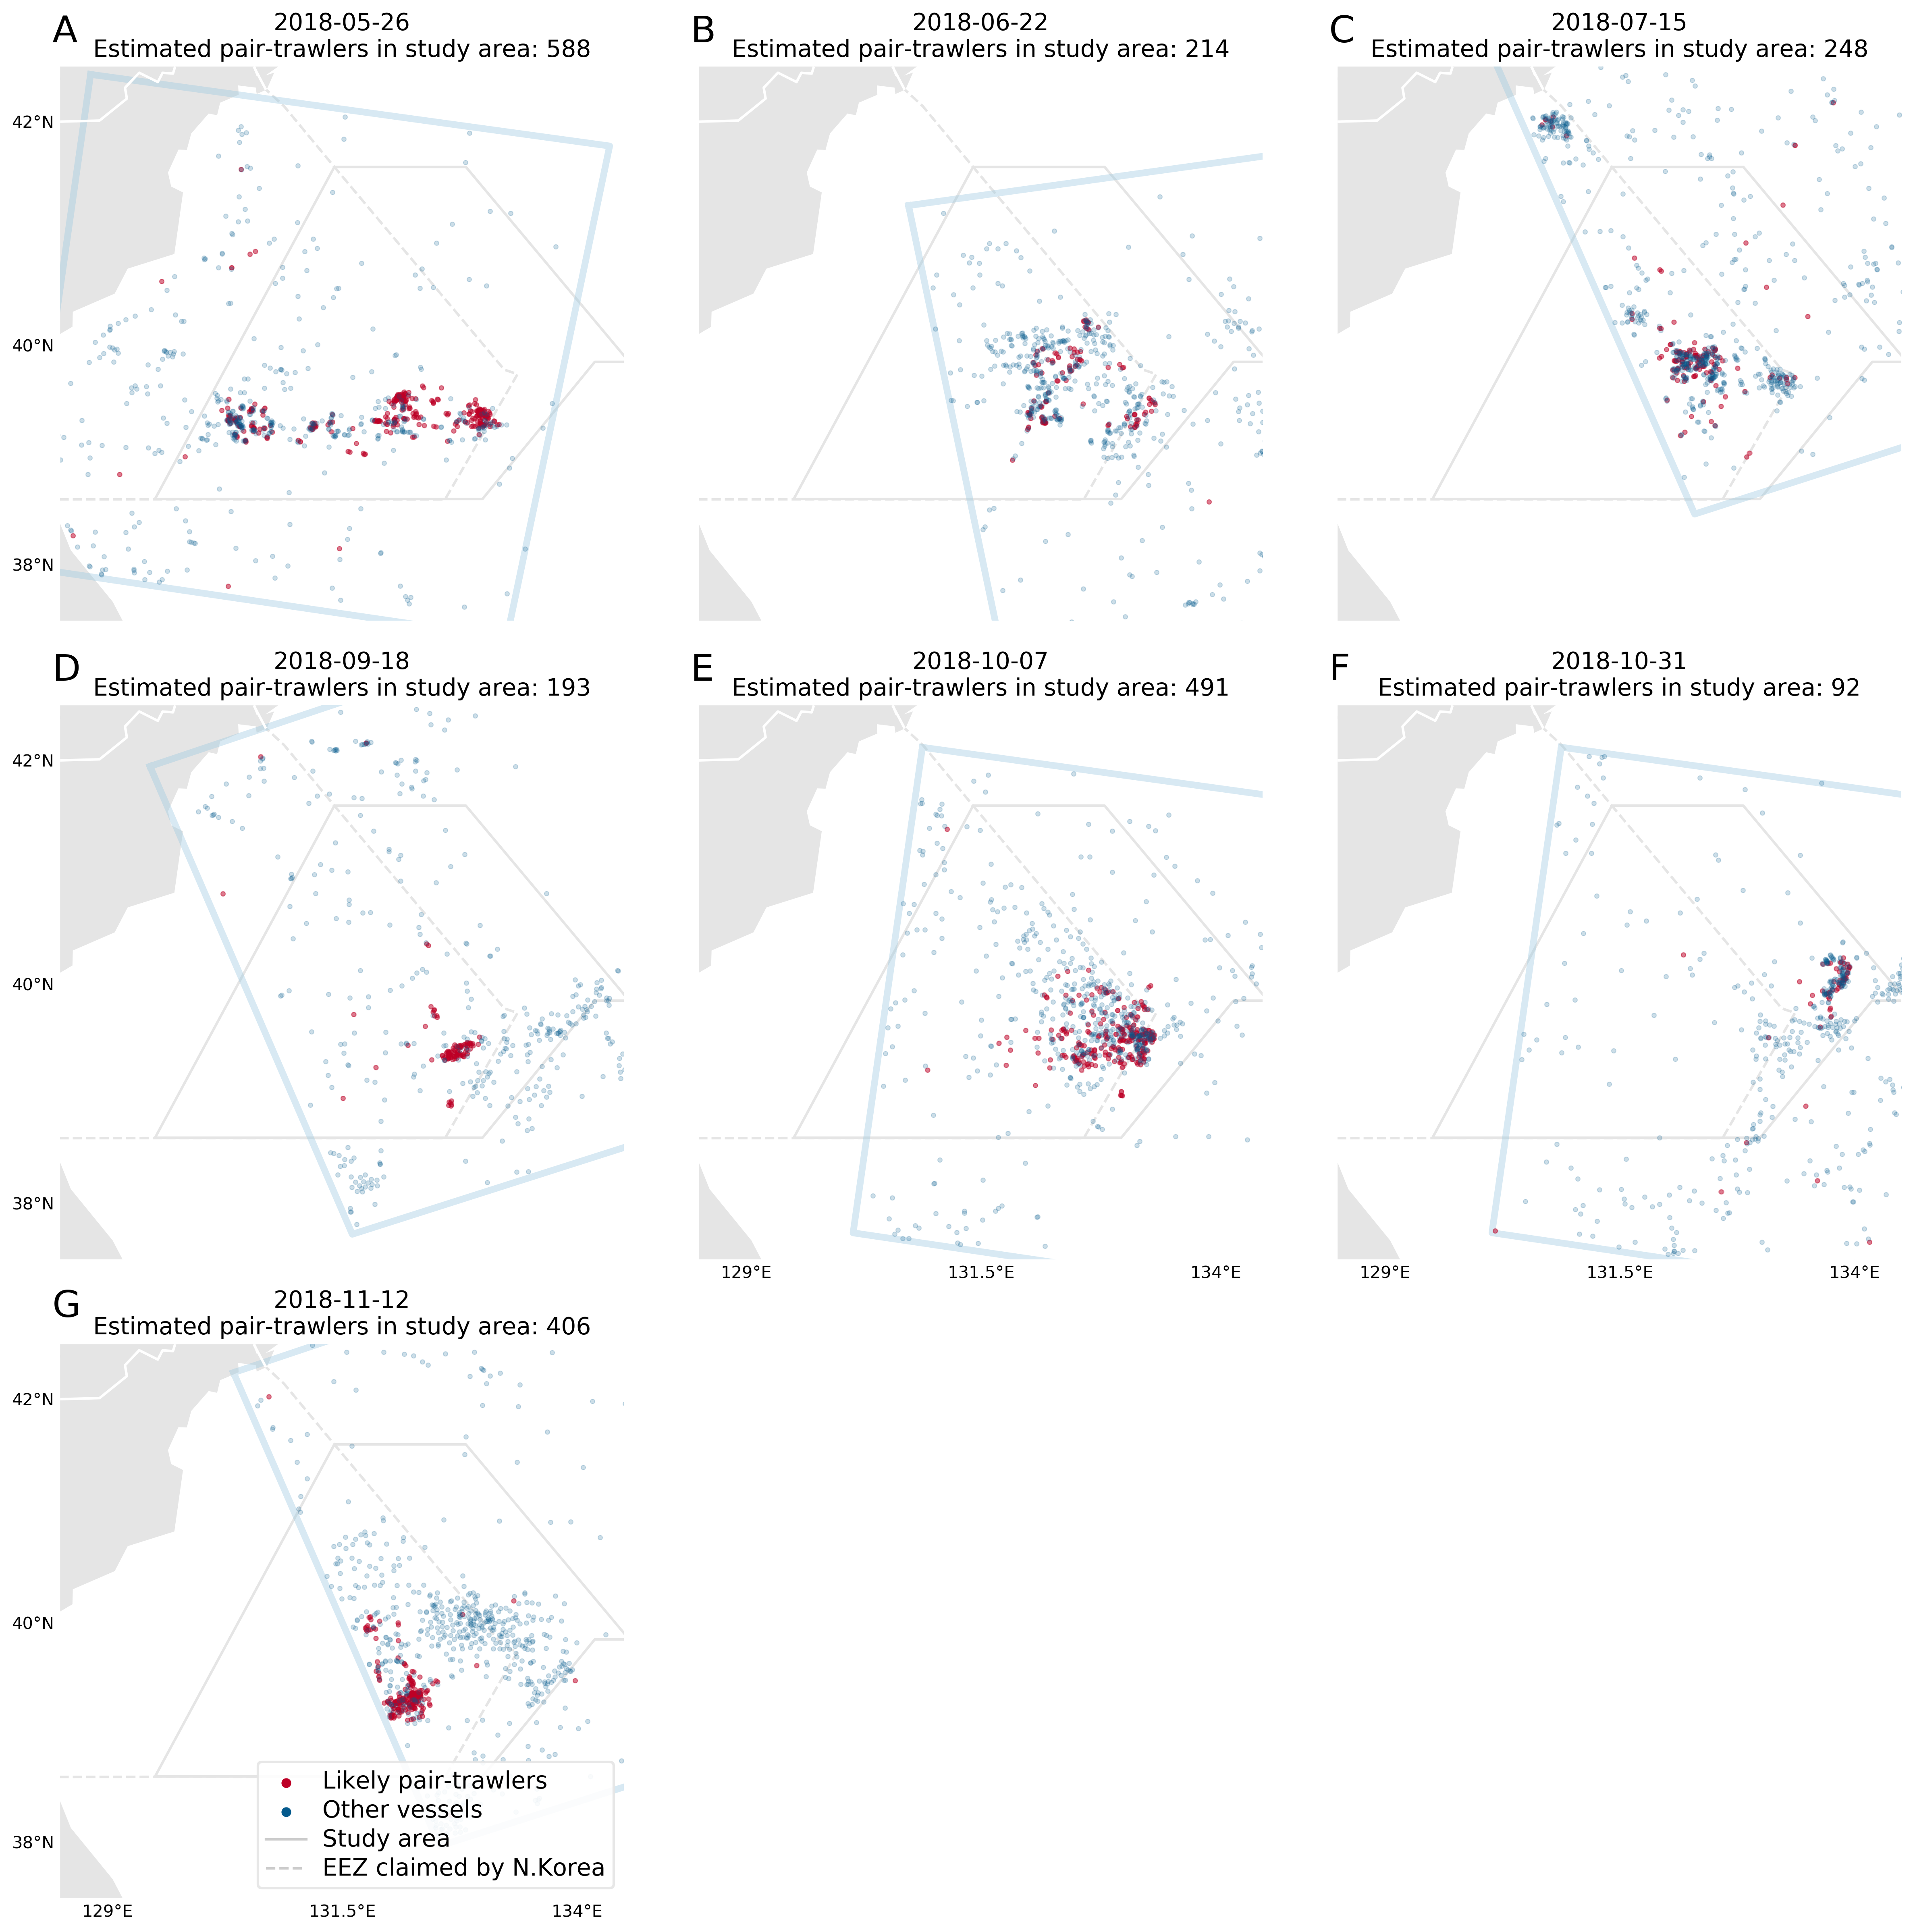

In [36]:
r2_plot()

# Fig.1F - Activity of Chinese pair trawlers in North Korea

In [37]:
#
# Create Fig.1F that displays pair trawler activity 
# in North Korean waters on 2017-10-08
#
def sar_pair_trawlers(df):
    #
    # default map setting
    llcrnrlon = 129
    urcrnrlon = 135
    llcrnrlat = 36.9
    urcrnrlat = 42.4

    #
    # default Basemap setting
    fig = plt.figure(figsize=(3.6,3.6), facecolor='white', dpi=300)
    ax = fig.add_subplot(111)
    m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
                lat_ts=0, projection='mill', resolution="l", suppress_ticks=True)
    m.drawmapboundary(fill_color='white', color='#b2b2b2') 
    m.fillcontinents(color='#b2b2b2', lake_color='#b2b2b2', zorder=1.0)
    
    #
    # Read boundary shapefiles
    m.readshapefile(_study_area, 'sa', zorder=1.5,
                    linewidth=1.0, color='#b2b2b2')
    prk = m.readshapefile(_eez_prk_no_shoreline, 'prk', zorder=0.5,
                          linewidth=1.0, color='#b2b2b2')
    prk[-1].set_linestyle('--')
    m.plot([], [], alpha=0.4, color='#045a8d', label='RADARSAT-2 Footprint')

    #
    # Radarsat-2 boundary
    boundary = r2boundary[4]
    boundary = pd.DataFrame(r2boundary[4], columns=['lat','lon'])
    lon, lat = m(boundary['lon'].values, boundary['lat'].values)
    m.plot(lon, lat, linewidth=3, c='#045a8d', alpha=0.4, zorder=1.5)

    #
    # Plot detected vessels 
    pairt = df[df['pair_trawler'] == True]
    other = df[df['pair_trawler'] == False]
    lon, lat = m(pairt['lon'].values, pairt['lat'].values)
    m.scatter(lon, lat, color='#bd0026', s=4, alpha=0.3, edgecolor='none',
              zorder=2, label='Pair Trawler Detection')
    lon, lat = m(other['lon'].values, other['lat'].values)
    m.scatter(lon, lat, color='#045a8d', s=4, alpha=0.1, edgecolor='none',
              zorder=2, label='Other Vessel Detection')
    
    fig.text(0.25,0.30, '2018-10-07 SAR Detections', fontsize=10, ha='left',
             bbox=dict(facecolor='white', edgecolor='none',pad=0.9, alpha=0.8))
    
    #
    # Handle legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,2,0]#,0,1]
    leg = plt.legend([handles[idx] for idx in order],
                     [labels[idx] for idx in order], 
                     loc=3, bbox_to_anchor=(0.09,-0.0), 
                     frameon=True, borderpad=0.3, markerscale=2, 
                     fontsize=12, labelspacing=0.1, handlelength=1.5) 

    for text in leg.get_texts():
        text.set_color("black")
        text.set_fontsize(10)
    for lh in leg.legendHandles: 
        lh.set_alpha(0.4)
        lh.set_linewidth(3.0)
    for p in leg.get_patches():
        p.set_color('#E5E5E5')
        p.set_alpha(1)
    frame = leg.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('none')
    frame.set_linewidth(1.0)
    frame.set_alpha(0.8)

    #
    # axes, figures, labels, title
    ax = plt.gca()
    xtick1,_ = m(130,0)
    xtick2,_ = m(134,0)
    _,ytick1 = m(0,38)
    _,ytick2 = m(0,41)
    
    ax.set_xticks([xtick1, xtick2])
    ax.set_xticklabels(['130'+u"\u00b0"+'E', '134'+u"\u00b0"+'E'])
    ax.tick_params(axis="x", direction="out", color='#b2b2b2', labelsize=10)
    ax.set_yticks([ytick1, ytick2])
    ax.set_yticklabels(['38'+u"\u00b0"+'N', '41'+u"\u00b0"+'N'])
    ax.tick_params(axis="y", direction="out", color='#b2b2b2', labelsize=10)
    ax.grid(False)
    
    fig.tight_layout()
    plt.subplots_adjust()
    plt.show()

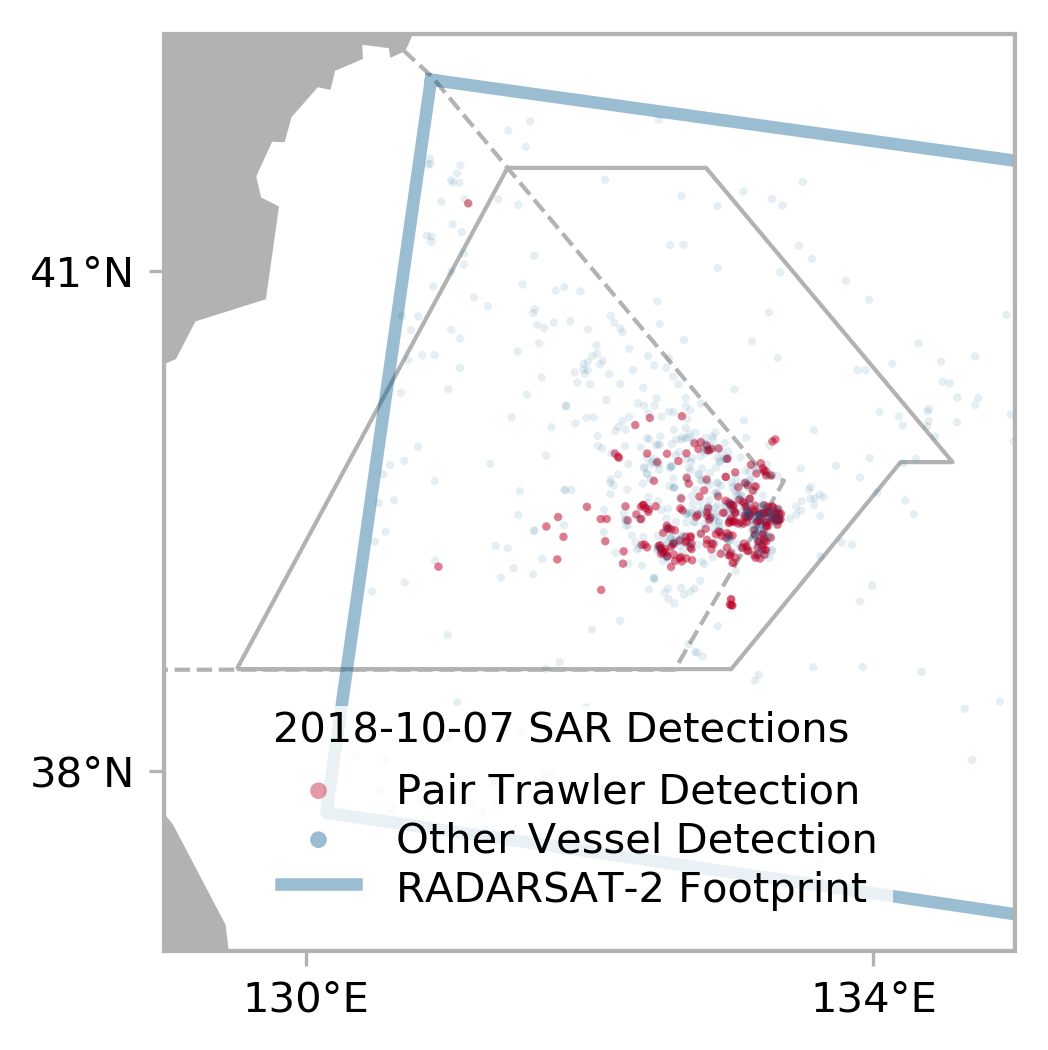

In [38]:
sar_pair_trawlers(r2[r2['date']=='20181007'])

# Sentinel-1 detections

## Fig.S10 - Examples of Sentinel-1 detection maps

In [40]:
#
# Likely pair trawlers based on Sentinel-1 vessel detection
#
q = """
# StandardSQL
#
# Detect likely pair trawlers based on the distance to the nearest neighbor
WITH 
  #
  # Data points of the SAR detection
  data AS (
    SELECT 
      CONCAT(SAFE_CAST(date AS STRING), '_' ,
            SAFE_CAST(ROUND(lat,6) AS STRING), '_',
            SAFE_CAST(ROUND(lon,6) AS STRING)) AS vid, 
      *
    FROM (
      SELECT 
        ST_GEOGPOINT(lon, lat) AS loc, 
        lat, lon, date
      FROM `paper_dark_fishing_fleets_in_north_korea.sar_sentinel1_detections` ) 
  ),

  #
  # Area of interest (within the claimed N.Korea EEZ excluding the military zone)
  aoi AS (
    SELECT aoi AS polygon
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_eez_wo_mz` 
  ),
    
  #
  # Shorelines of the eastern part of N.Korea
  sl AS (
    SELECT ST_MAKELINE(shoreline) AS shorelines 
    FROM `paper_dark_fishing_fleets_in_north_korea.aoi_prk_shorelines`
  )
  
#
# Mark the data points whose nearest neighbor is located within 535 meters
# and whether the data points are within the area of interest
SELECT 
  vid, date, lat, lon, in_aoi, 
  IF(nearest<=535, TRUE, FALSE) AS pair_trawler
FROM (
  SELECT 
    vid, date, lat, lon, distance, 
    FIRST_VALUE(distance) OVER (PARTITION BY vid ORDER BY distance ASC) AS nearest, 
    IF(ST_CONTAINS( (SELECT polygon FROM aoi), loc), TRUE, FALSE) AS in_aoi
  FROM (
    #
    # Cross-join the dataset to calculate the distance 
    # between each data points on the same date
    SELECT 
      vid, date, lat, lon, loc, 
      ST_DISTANCE(loc, loc2) AS distance, 
      vid2 
    FROM data a
    JOIN (
      SELECT vid AS vid2, date, loc AS loc2 
      FROM data ) b
    USING (date) )
  #
  # Remove the points themselves (with the distance = 0)
  # and filter in only those that are 12 nautical miles away from the coastline
  WHERE vid != vid2
    AND ST_DISTANCE(loc, (SELECT shorelines FROM sl)) > 22224 )
WHERE nearest = distance
"""
s1 = pd.read_gbq(q, project_id='global-fishing-watch', dialect='standard')

In [41]:
#
# Plot some selected examples of Sentinel-1 detections
#
def s1_plot_selected(dlist):

    fig = plt.figure(figsize=(16,17.5), dpi=300)
    count=0
    vnum = []
    for i in range(0,9,1):
        date = dlist[i]
        #date = datetime.datetime.strftime(date, "%Y-%m-%d")
        s1_date = s1[s1['date']==date]

        #
        # default map setting
        llcrnrlon = 127.5
        urcrnrlon = 133.5
        llcrnrlat = 37.5
        urcrnrlat = 42.5

        col = int(count%3)
        row = int(count/3)

        #
        # default Basemap setting
        ax = fig.add_subplot(3, 3, (row*3) + col + 1)
        m = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                    urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
                    lat_ts=0, projection='mill', resolution="l")
        m.drawmapboundary(fill_color='white', color='white', zorder=0.5) 
        m.fillcontinents(color='#E5E5E5', lake_color='#E5E5E5', zorder=1) 
        m.drawcountries(color='white', linewidth=1.5)

        #
        # set longitude, latitude ticks on x- and y-axes
        gap_lat = 2
        gap_lon = 2.5
        med_lat = 40.0
        med_lon = 130.5
        num_tick_lat = 3
        num_tick_lon = 3
        if col==0:
            m.drawparallels(np.arange(med_lat-gap_lat, med_lat+gap_lat+1, gap_lat),
                            labels=[1,0,0,0], linewidth=0.01, zorder=0)
        if count>=6:
            m.drawmeridians(np.arange(med_lon-gap_lon, med_lon+gap_lon+1, gap_lon),
                            labels=[0,0,0,1], linewidth=0.01, zorder=0)

        #
        # Read boundary shapefiles
        m.readshapefile(_study_area, 'prk', zorder=1.5, 
                        linewidth=1.5, color='#E5E5E5')
        prk = m.readshapefile(_eez_prk_no_shoreline, 'prk', zorder=1., 
                              linewidth=1.5, color='#e5e5e5')
        prk[-1].set_linestyle('--')
        
        #
        # Boundary labels
        m.plot([], [], linewidth=1.5, alpha=0.8, color='#CCCCCC', 
               label='Study area')
        m.plot([], [], linewidth=1.5, linestyle='--', alpha=0.8, color='#CCCCCC', 
               label='EEZ claimed by N.Korea')

        #
        # Sentinel-1 boundary
        boundary = [[129.73523698027714, 43.72170826252623],
                    [128.45248171066214, 37.72000402362929],
                    [131.2543808165592, 37.32622410660575],
                    [132.7609091784709, 43.33360538938801],
                    [129.73523698027714, 43.72170826252623]]
        
        #for b_lon, b_lat in pd.DataFrame(boundary):
        boundary = pd.DataFrame(boundary, columns=['lon','lat'])
        lon, lat = m(boundary['lon'].values, boundary['lat'].values)
        m.plot(lon, lat, linewidth=4, c='#9ecae1', alpha=0.4, zorder=1.5)

        #
        # Plot
        pairt = s1_date[s1_date['pair_trawler'] == True]
        other = s1_date[s1_date['pair_trawler'] == False]
        lon, lat = m(pairt['lon'].values, pairt['lat'].values)
        m.scatter(lon, lat, color='#bd0026', s=7, alpha=0.3, zorder=2, 
                  label='Likely pair-trawlers')
        lon, lat = m(other['lon'].values, other['lat'].values)
        m.scatter(lon, lat, color='#045a8d', s=7, alpha=0.2, zorder=2, 
                  label='Other vessels')
    
        #
        # Handle legend
        if i==8:
            handles, labels = plt.gca().get_legend_handles_labels()
            order = [2,3,0,1]
            leg = plt.legend([handles[idx] for idx in order],
                             [labels[idx] for idx in order], 
                             loc=4, bbox_to_anchor=(1.0,-0.0),
                             frameon=True, markerscale=2, fontsize=12, labelspacing=0.3)

            for text in leg.get_texts():
                text.set_color("black")
                text.set_fontsize(14)
            for lh in leg.legendHandles: 
                lh.set_alpha(1)
            for p in leg.get_patches():
                p.set_color('#E5E5E5')
                p.set_alpha(1)
            frame = leg.get_frame()
            frame.set_facecolor('white')
            frame.set_edgecolor('#e5e5e5')
            frame.set_linewidth(1.5)
            frame.set_alpha(0.9)

        #
        # axes, figures, labels, title
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        n1 = len(sar_within(pairt, _eez_prk_wo_mz))
        n2 = len(sar_within(other, _eez_prk_wo_mz))

        vnum.append(n1) 
        ax.set_title('{}\nEstimated pair-trawlers in study area: {}'\
                     .format(dlist[i],n1), fontsize=14) 
        count+=1

    title = ['A','B','C','D','E','F','G','H','I']
    tlocx = [0.02,0.35,0.68]
    tlocy = [0.968,0.642,0.313]
    for i in range(9):
        col = int(i%3)
        row = int(i/3)
        fig.text(tlocx[col], tlocy[row], title[i], fontsize=22, ha='left', va='bottom') 
        
    fig.tight_layout()
    plt.subplots_adjust()
    plt.show()

In [42]:
selected = ['2017-05-08',
            '2017-05-20',
            '2017-06-01',
            '2017-07-19',
            '2018-05-15',
            '2018-06-08',
            '2017-10-23',
            '2017-11-16',
            '2018-10-06']

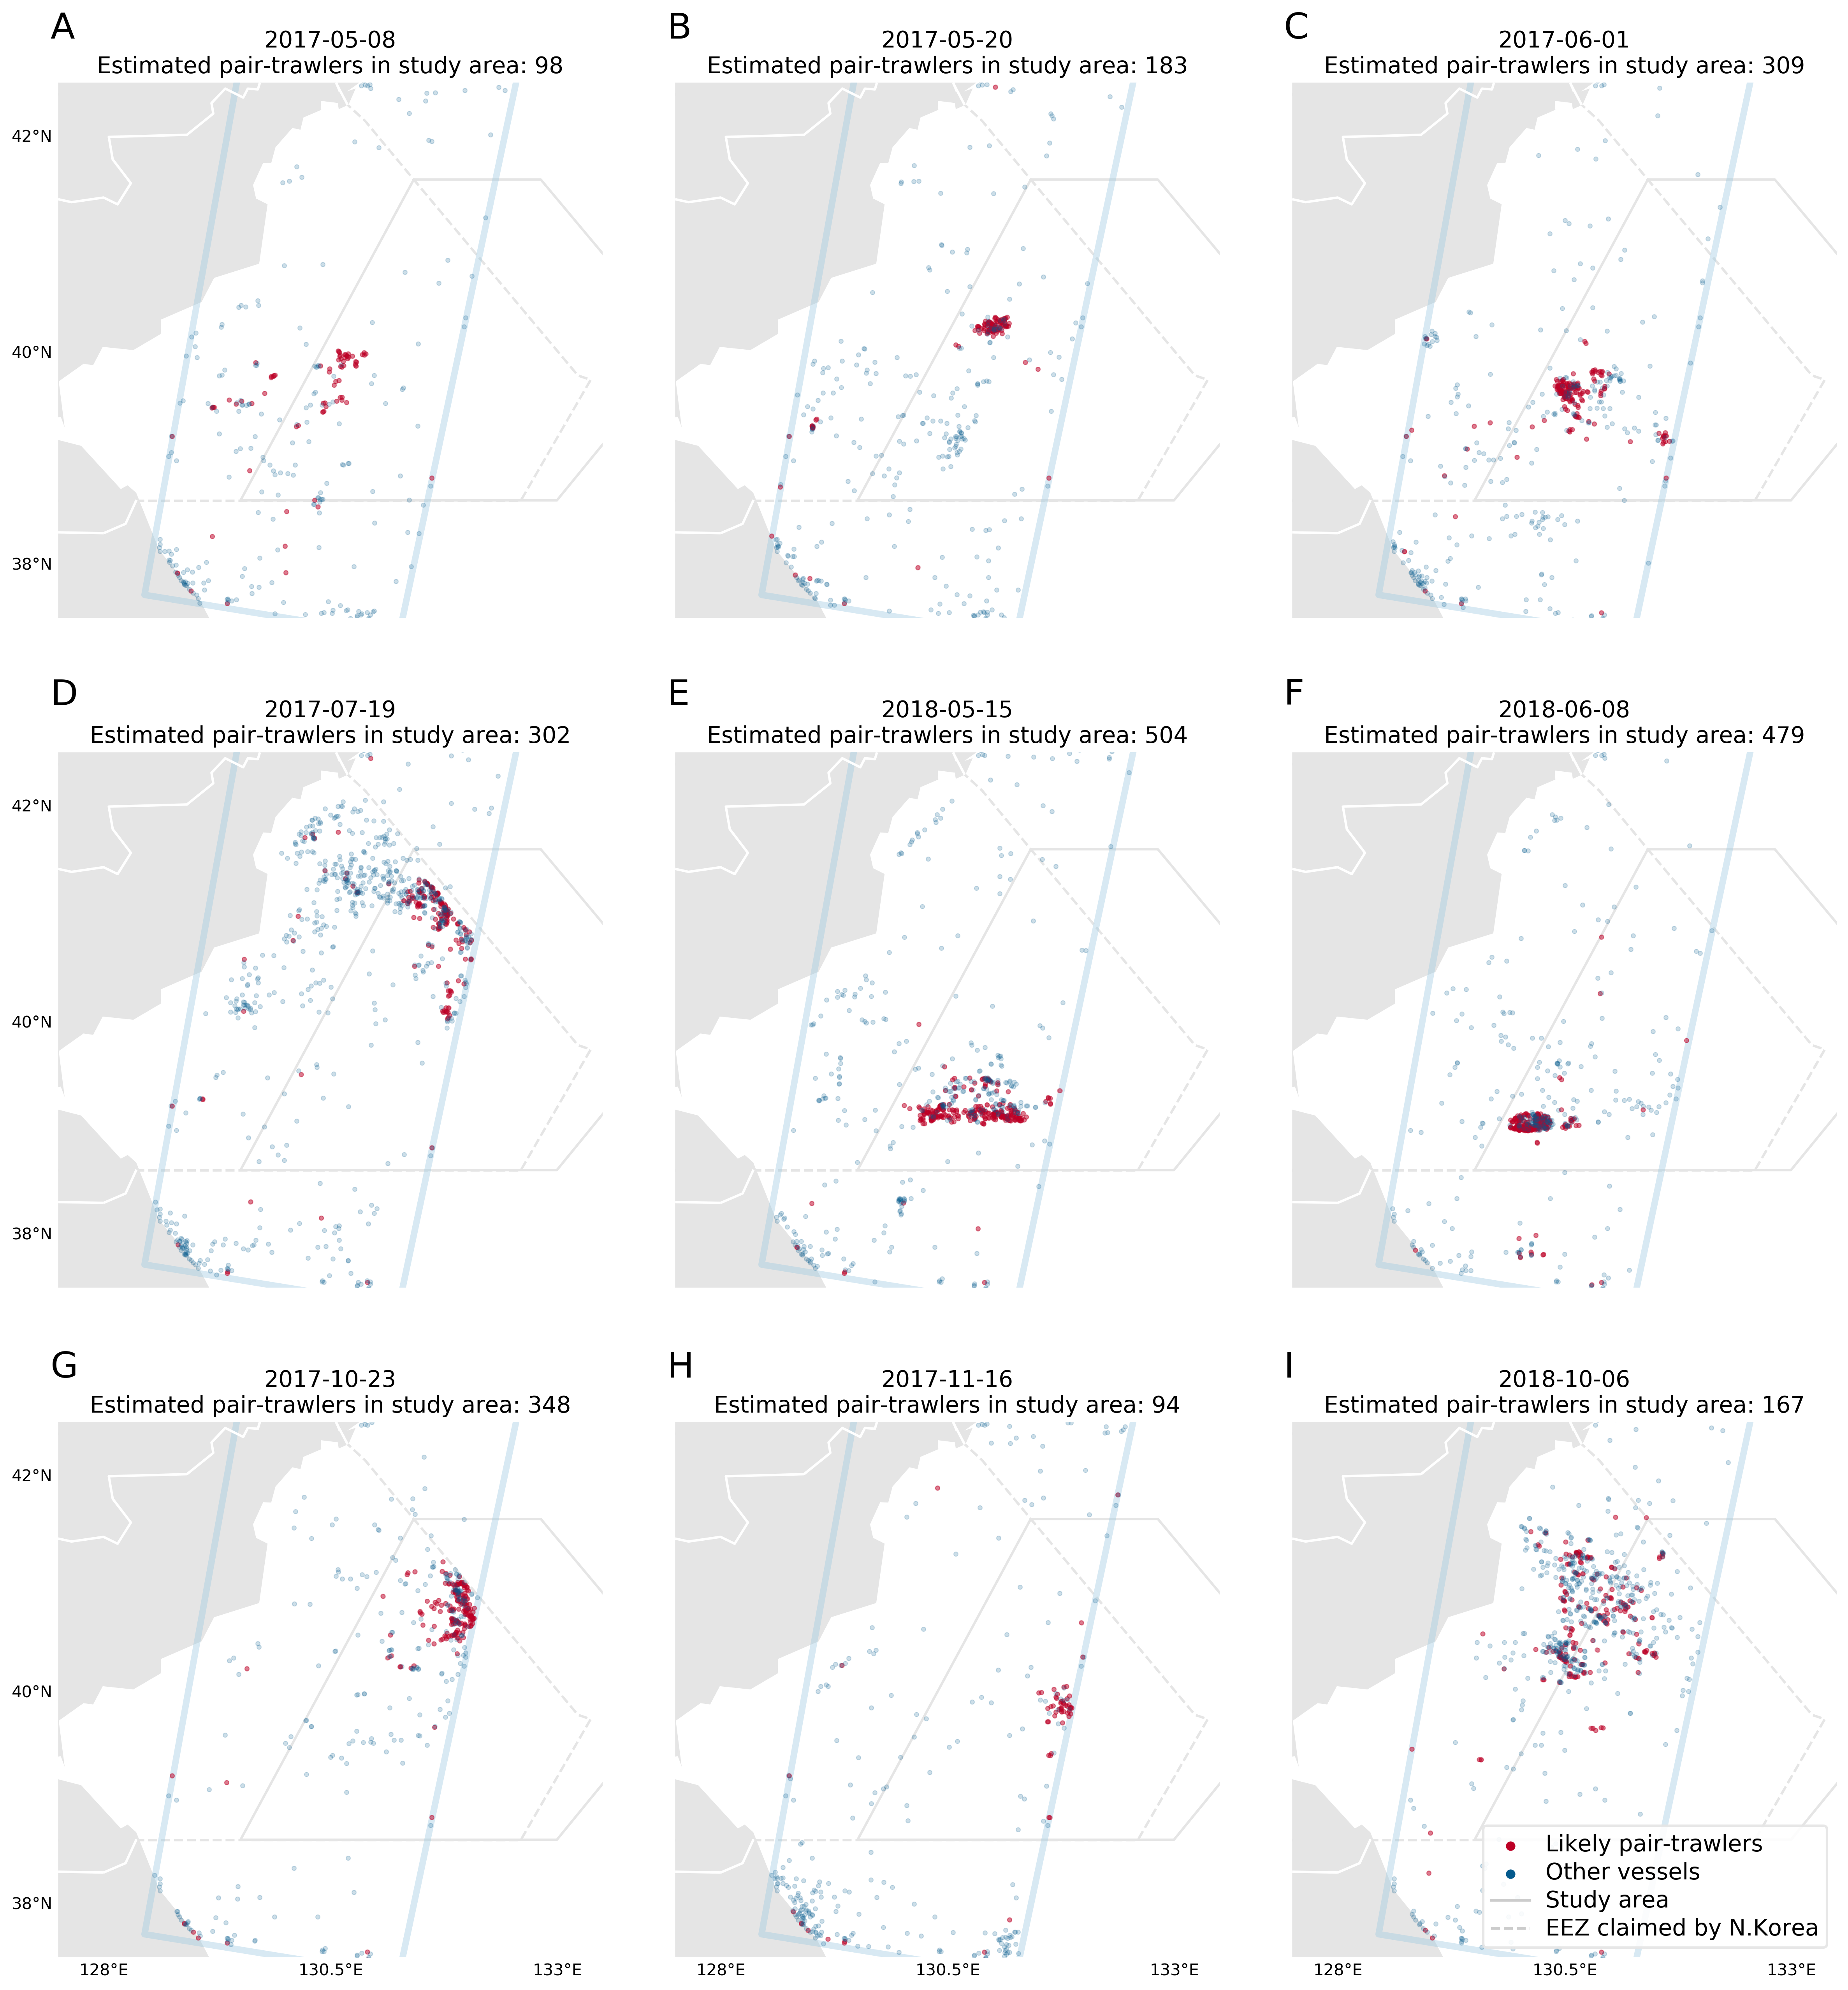

In [43]:
s1_plot_selected(selected)